In [15]:
# our standard imports 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as miss


# Preprocessing tools
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

# Models and evaluation metrics
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import joblib
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
# setting random state for reproducibility
SEED = 321
np.random.seed(SEED)
## matplotlib style


fav_style = ('ggplot','tableau-colorblind10')
fav_context = {'context':'notebook', 'font_scale':1.1}
plt.style.use(fav_style)
sns.set_context(**fav_context)
plt.rcParams['savefig.transparent'] = False
plt.rcParams['savefig.bbox'] = 'tight'

# Set global scikit_learn configuration
from sklearn import set_config
set_config(display='diagram')

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
fav_style = ('ggplot','tableau-colorblind10')
fav_context  ={'context':'notebook', 'font_scale':1.2}
plt.style.use(fav_style)
sns.set_context(**fav_context)
plt.rcParams['savefig.transparent'] = False
plt.rcParams['savefig.bbox'] = 'tight'

In [24]:
def evaluate_regression(model, X_train,y_train, X_test, y_test,for_slides=True): 
    """Evaluates a scikit learn regression model using r-squared and RMSE
    FOR SLIDES VERS DOES MULTIPLE PRINT STATEMENTS FOR VERTICAL DISPLAY OF INFO"""
    
    ## Training Data
    y_pred_train = model.predict(X_train)
    r2_train = metrics.r2_score(y_train, y_pred_train)
    rmse_train = metrics.mean_squared_error(y_train, y_pred_train, 
                                            squared=False)
    mae_train = metrics.mean_absolute_error(y_train, y_pred_train)
    

    ## Test Data
    y_pred_test = model.predict(X_test)
    r2_test = metrics.r2_score(y_test, y_pred_test)
    rmse_test = metrics.mean_squared_error(y_test, y_pred_test, 
                                            squared=False)
    mae_test = metrics.mean_absolute_error(y_test, y_pred_test)
    
    if for_slides:
        df_version =[['Split','R^2','MAE','RMSE']]
        df_version.append(['Train',r2_train, mae_train, rmse_train])
        df_version.append(['Test',r2_test, mae_test, rmse_test])
        df_results = pd.DataFrame(df_version[1:], columns=df_version[0])
        df_results = df_results.round(2)
        display(df_results.style.hide(axis='index').format(precision=2, thousands=','))
        
    else: 
        print(f"Training Data:\tR^2 = {r2_train:,.2f}\tRMSE = {rmse_train:,.2f}\tMAE = {mae_train:,.2f}")
        print(f"Test Data:\tR^2 = {r2_test:,.2f}\tRMSE = {rmse_test:,.2f}\tMAE = {mae_test:,.2f}")

def get_coefficients(lin_reg):
    coeffs = pd.Series(lin_reg.coef_, index= lin_reg.feature_names_in_)
    coeffs.loc['intercept'] = lin_reg.intercept_
    return coeffs

def plot_coefficients(coeffs, sort_values=True, top_n=None, figsize=(6,4),
                     title="Linear Regression Coefficients", xlabel='Coefficient'):
    """Plots a Series of coefficients as horizotal bar chart, with option to sort
    and to only keep top_n coefficients"""
        
    if top_n is not None:
        top_n = coeffs.abs().rank().sort_values(ascending=False).head(top_n)
        coeffs = coeffs.loc[top_n.index]
        
    if sort_values:
        coeffs = coeffs.sort_values()

        
        
    ax = coeffs.plot(kind='barh', figsize=figsize)
    ax.axvline(0, color='k')
    ax.set(xlabel=xlabel, title=title);
    plt.show()
    return ax


def get_importances(rf_reg):
    importances = pd.Series(rf_reg.feature_importances_, index= rf_reg.feature_names_in_)
    return importances


def plot_importances(importances, sort_values=True, top_n=None, figsize=(6,4),
                     title="Feature Importance", xlabel='Importance'):
    if sort_values:
        importances = importances.sort_values()
        
    if top_n is not None:
        importances = importances.tail(top_n)
        
        
    ax = importances.plot(kind='barh', figsize=figsize)
    ax.axvline(0, color='k')
    ax.set(xlabel=xlabel, title=title);
    plt.show()
    return ax

In [25]:
## Load the joblib file stored in the models folder
fname = "Best models.joblib"

loaded = joblib.load(fname)
# Preview the contents of the loaded joblib objects
loaded.keys()

dict_keys(['X_train', 'y_train', 'X_test', 'y_test', 'preprocessor', 'LinearRegression', 'RandomForestRegressor'])

In [26]:
X_train = loaded['X_train']
X_test = loaded['X_test']
y_train = loaded['y_train']
y_test = loaded['y_test']

preprocessor = loaded['preprocessor']
lin_reg_final = loaded['LinearRegression']
rf_reg = loaded['RandomForestRegressor']

In [30]:
feature_names = preprocessor.get_feature_names_out()

## Use the preprocessor to transform X_train into X_train_df
X_train_df = pd.DataFrame(preprocessor.transform(X_train),
                          index=X_train.index,
                          columns=feature_names)


## Use the preprocessor to transform X_test into X_test_df 

X_test_df = pd.DataFrame(preprocessor.transform(X_test),
                         index=X_test.index,
                          columns=feature_names)
X_train_df.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Fat_Content_Regular,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,...,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Size_Unknown,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
8269,7.220,0.064142,61.2510,1998.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
7604,6.135,0.079294,111.2860,2009.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2762,12.150,0.028593,151.0708,2004.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
6464,5.945,0.093009,127.8652,2004.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4707,18.200,0.066285,247.2092,2004.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [31]:
## using my evaluation function to see the metrics
evaluate_regression(lin_reg_final, X_train_df, y_train, X_test_df, y_test)

Split,R^2,MAE,RMSE
Train,0.56,826.82,"1,114.97"
Test,0.56,859.99,"1,164.44"


In [32]:
pd.set_option('display.float_format',lambda x: f"{x:,.2f}")

coeffs = get_coefficients(lin_reg_final)
coeffs

Item_Weight                          1.42
Item_Visibility                   -276.34
Item_MRP                            15.60
Outlet_Establishment_Year           -0.14
Item_Fat_Content_Regular            31.53
Item_Type_Baking Goods               9.26
Item_Type_Breads                    -3.13
Item_Type_Breakfast                 69.92
Item_Type_Canned                    22.78
Item_Type_Dairy                    -48.91
Item_Type_Frozen Foods              -5.22
Item_Type_Fruits and Vegetables     15.95
Item_Type_Hard Drinks               50.06
Item_Type_Health and Hygiene       -41.46
Item_Type_Household                -68.97
Item_Type_Meat                     -15.81
Item_Type_Others                    17.14
Item_Type_Seafood                   99.00
Item_Type_Snack Foods              -11.68
Item_Type_Soft Drinks             -117.34
Item_Type_Starchy Foods             30.54
Outlet_Identifier_OUT010          -461.76
Outlet_Identifier_OUT013            -0.97
Outlet_Identifier_OUT017          

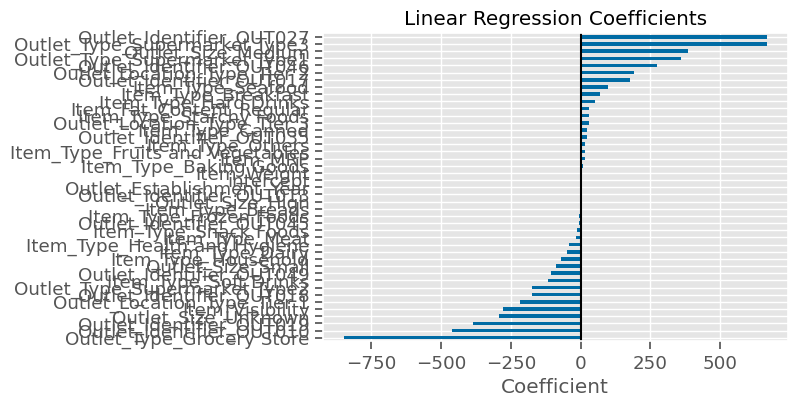

<AxesSubplot: title={'center': 'Linear Regression Coefficients'}, xlabel='Coefficient'>

In [33]:
## plotting the coefficients
plot_coefficients(coeffs)

## Evaulating the Random Forest

Split,R^2,MAE,RMSE
Train,0.94,291.12,420.86
Test,0.57,810.67,"1,152.04"


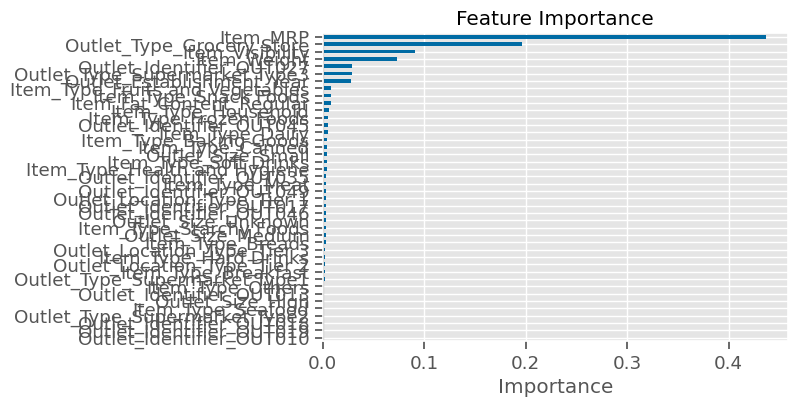

<AxesSubplot: title={'center': 'Feature Importance'}, xlabel='Importance'>

In [34]:
# measuring the random forest metrics
evaluate_regression(rf_reg,X_train_df,y_train, X_test_df, y_test)

## extract the plot the feature importances
importances = get_importances(rf_reg)
plot_importances(importances)

## Permutation Importance for random forest

In [35]:
from sklearn.inspection import permutation_importance
## running the performatation importance on the random forest
result = permutation_importance(rf_reg, X_test_df, y_test,scoring='r2',
                                n_jobs=-1,random_state=SEED)
result.keys()

dict_keys(['importances_mean', 'importances_std', 'importances'])

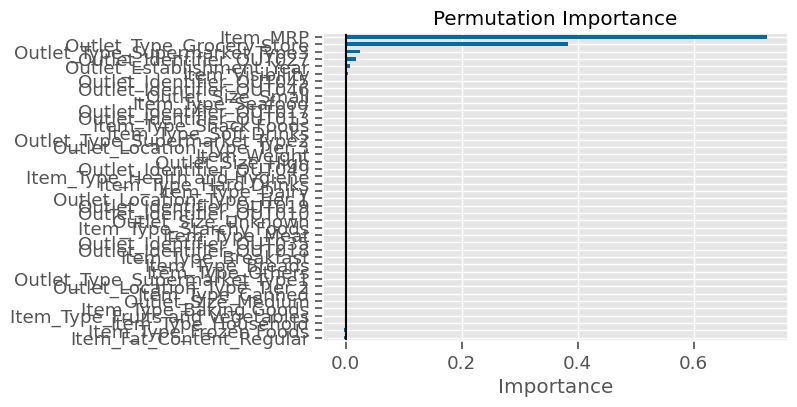

<AxesSubplot: title={'center': 'Permutation Importance'}, xlabel='Importance'>

In [37]:
## saving the average importances as a Series
perm_importances = pd.Series(result['importances_mean'], index=rf_reg.feature_names_in_)

plot_importances(perm_importances,title='Permutation Importance')

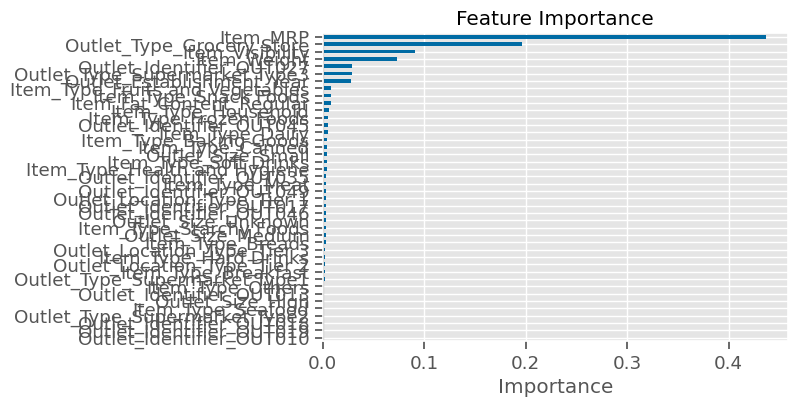

<AxesSubplot: title={'center': 'Feature Importance'}, xlabel='Importance'>

In [38]:
# Comparing to the random forst feature importance
plot_importances(importances)

## LinearRegression Permutation Importance

In [39]:
## running the performatation importance on the random forest
results_linreg = permutation_importance(lin_reg_final, X_test_df, y_test,scoring='r2', n_repeats=3,
                                n_jobs=-1,random_state=SEED)
result.keys()

dict_keys(['importances_mean', 'importances_std', 'importances'])

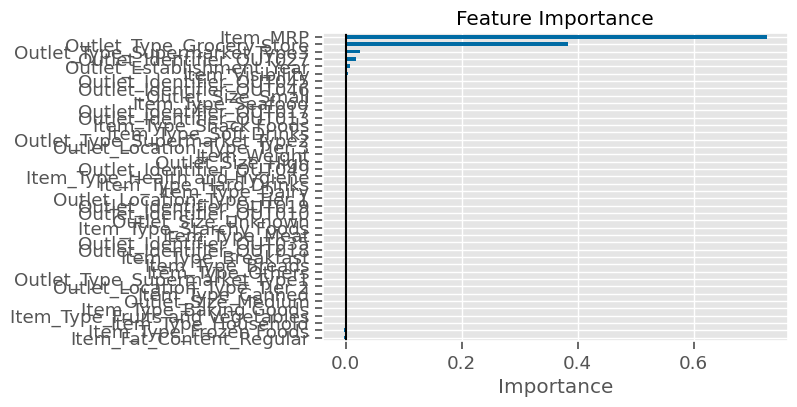

<AxesSubplot: title={'center': 'Feature Importance'}, xlabel='Importance'>

In [40]:
perm_importances_linreg = pd.Series(result['importances_mean'], 
                                    index=lin_reg_final.feature_names_in_)

plot_importances(perm_importances_linreg)

In [41]:
final_plot_df = pd.concat([X_train_df, y_train], axis=1)
corr = final_plot_df.corr()
corr

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Fat_Content_Regular,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,...,Outlet_Size_Small,Outlet_Size_Unknown,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,Item_Outlet_Sales
Item_Weight,1.00,-0.01,0.03,-0.02,-0.03,-0.03,-0.06,0.00,-0.03,0.03,...,0.00,-0.01,0.01,-0.01,0.01,0.01,-0.01,-0.01,0.01,0.02
Item_Visibility,-0.01,1.00,0.01,-0.07,0.04,0.02,0.00,0.05,0.01,0.03,...,0.07,0.05,0.07,-0.07,0.00,0.29,-0.15,-0.03,-0.05,-0.13
Item_MRP,0.03,0.01,1.00,0.02,-0.00,-0.07,0.01,0.00,-0.02,0.03,...,0.02,0.00,0.00,0.01,-0.02,0.00,0.01,0.00,-0.02,0.57
Outlet_Establishment_Year,-0.02,-0.07,0.02,1.00,0.01,0.00,-0.00,-0.01,0.01,-0.02,...,-0.06,0.39,-0.21,0.54,-0.33,-0.29,0.25,0.47,-0.53,-0.03
Item_Fat_Content_Regular,-0.03,0.04,-0.00,0.01,1.00,0.08,0.04,0.06,0.08,0.01,...,-0.00,0.00,0.00,-0.00,0.00,0.00,-0.00,0.00,-0.00,0.01
Item_Type_Baking Goods,-0.03,0.02,-0.07,0.00,0.08,1.00,-0.05,-0.04,-0.08,-0.08,...,-0.01,0.01,-0.01,-0.00,0.01,0.01,-0.01,0.00,-0.00,-0.04
Item_Type_Breads,-0.06,0.00,0.01,-0.00,0.04,-0.05,1.00,-0.02,-0.05,-0.05,...,0.00,0.01,0.01,0.00,-0.01,0.01,-0.00,-0.01,0.00,0.00
Item_Type_Breakfast,0.00,0.05,0.00,-0.01,0.06,-0.04,-0.02,1.00,-0.03,-0.03,...,0.00,0.01,0.00,-0.00,0.00,0.02,-0.01,-0.00,-0.00,-0.00
Item_Type_Canned,-0.03,0.01,-0.02,0.01,0.08,-0.08,-0.05,-0.03,1.00,-0.08,...,0.01,-0.01,-0.00,0.01,-0.00,-0.01,-0.00,0.01,0.00,0.00
Item_Type_Dairy,0.03,0.03,0.03,-0.02,0.01,-0.08,-0.05,-0.03,-0.08,1.00,...,-0.00,-0.01,0.01,-0.01,0.00,0.01,0.01,-0.01,-0.00,0.01


In [44]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2131 entries, 8077 to 737
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Weight                2131 non-null   float64
 1   Item_Fat_Content           2131 non-null   object 
 2   Item_Visibility            2131 non-null   float64
 3   Item_Type                  2131 non-null   object 
 4   Item_MRP                   2131 non-null   float64
 5   Outlet_Identifier          2131 non-null   object 
 6   Outlet_Establishment_Year  2131 non-null   int64  
 7   Outlet_Size                2131 non-null   object 
 8   Outlet_Location_Type       2131 non-null   object 
 9   Outlet_Type                2131 non-null   object 
dtypes: float64(3), int64(1), object(6)
memory usage: 183.1+ KB


In [45]:
corr['Item_Outlet_Sales'].sort_values(ascending=False).to_frame().style.bar()


,Item_Outlet_Sales
Item_Outlet_Sales,1.000000
Item_MRP,0.566618
Outlet_Type_Supermarket Type3,0.299896
Outlet_Identifier_OUT027,0.299896
Outlet_Size_Medium,0.198352
Outlet_Type_Supermarket Type1,0.118424
Outlet_Location_Type_Tier 2,0.067244
Outlet_Identifier_OUT035,0.063430
Outlet_Location_Type_Tier 3,0.041279
Outlet_Identifier_OUT049,0.035054


## Global Model Explanations

In [46]:
import shap
shap.initjs()

In [47]:
## taking a sample of the training data
X_shap = shap.sample(X_train_df,nsamples = 500,random_state=SEED)
y_shap = y_train.loc[X_shap.index]
X_shap.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Fat_Content_Regular,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,...,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Size_Unknown,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
4469,7.72,0.07,76.40,"1,987.00",1.00,0.00,1.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00
4438,5.11,0.03,163.82,"2,004.00",0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00
366,8.05,0.08,256.46,"2,004.00",1.00,0.00,0.00,0.00,0.00,0.00,...,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00
2219,8.76,0.05,128.33,"1,999.00",0.00,0.00,0.00,0.00,0.00,0.00,...,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00
6080,6.59,0.18,82.79,"1,998.00",0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,1.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00


In [48]:
## instatiating a model explainer with the model
explainer = shap.Explainer(rf_reg)

## Getting shap values from the explainer
shap_values = explainer(X_shap,y_shap)

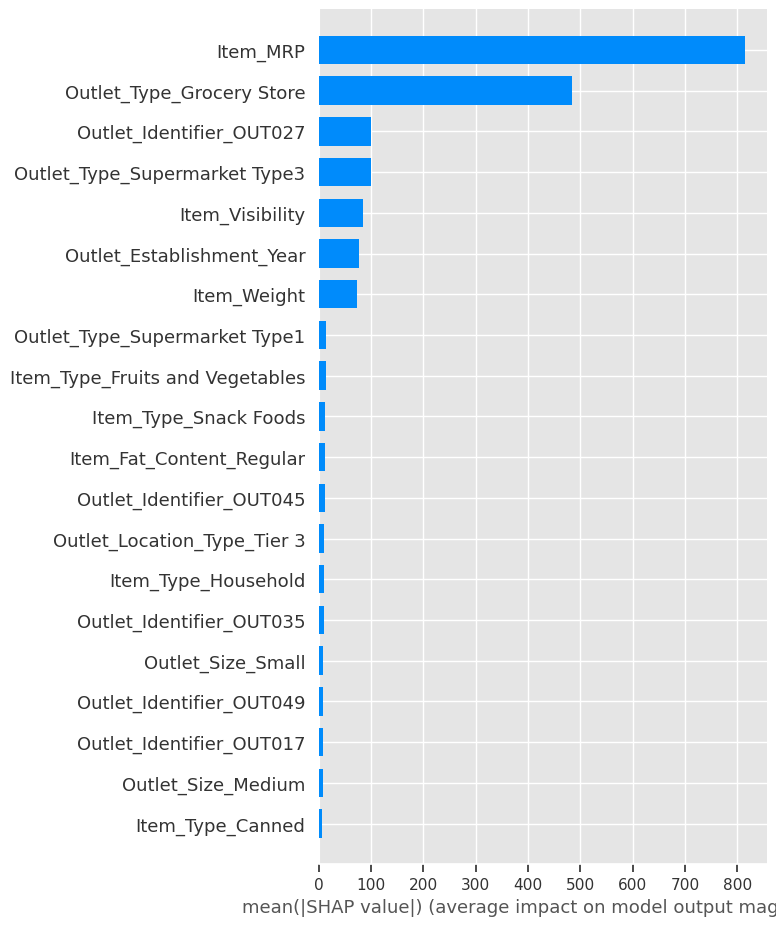

In [49]:
## creating a summary plot
shap.summary_plot(shap_values, features = X_shap, plot_type='bar')

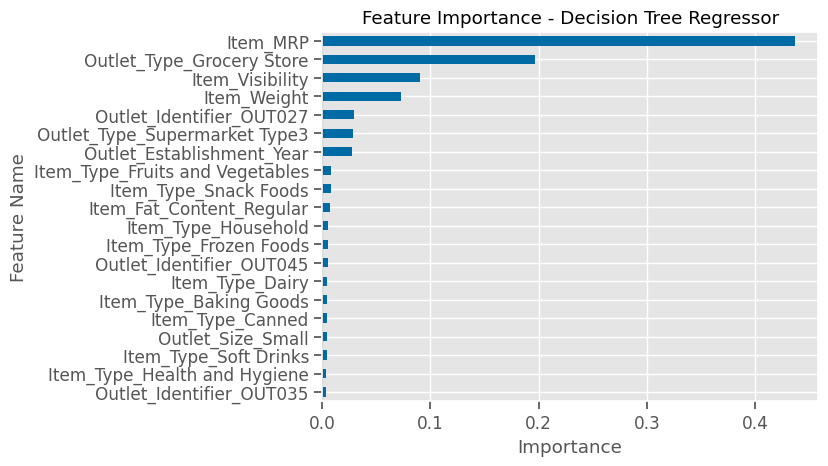

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


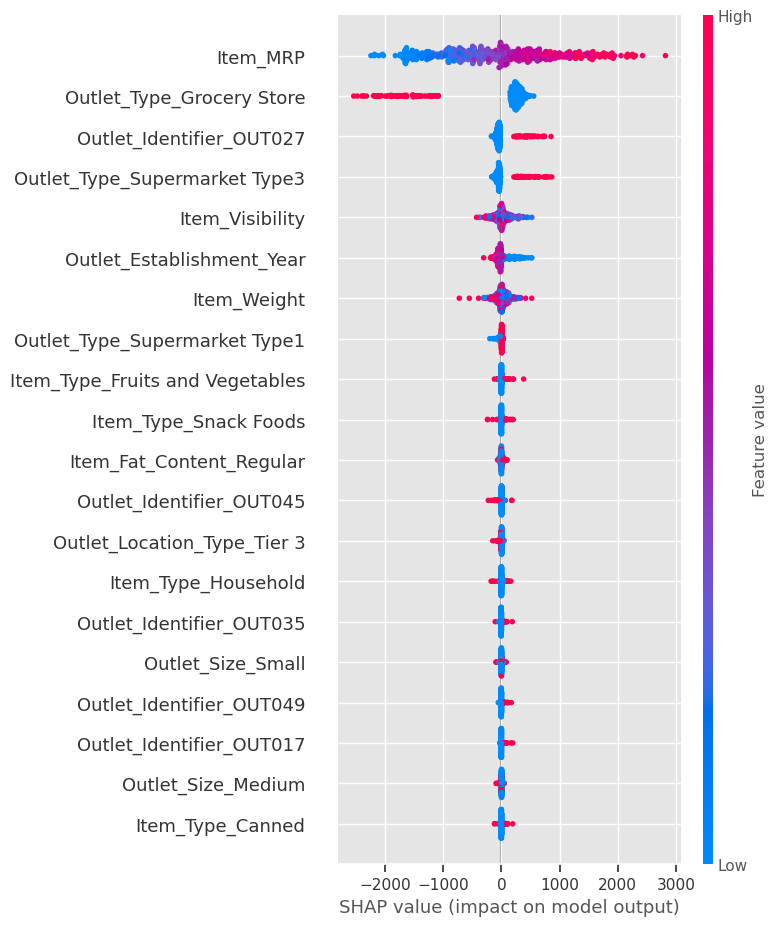

In [50]:
## creating a summary plot with the dot version
shap.summary_plot(shap_values, features = X_shap)

In [51]:
## Creating an explainer for the lin_reg
explainer_linreg = shap.Explainer(lin_reg_final, X_shap)

## get shap values for linreg
shap_values_linreg = explainer_linreg(X_shap)
shap_values_linreg.shape

(500, 42)

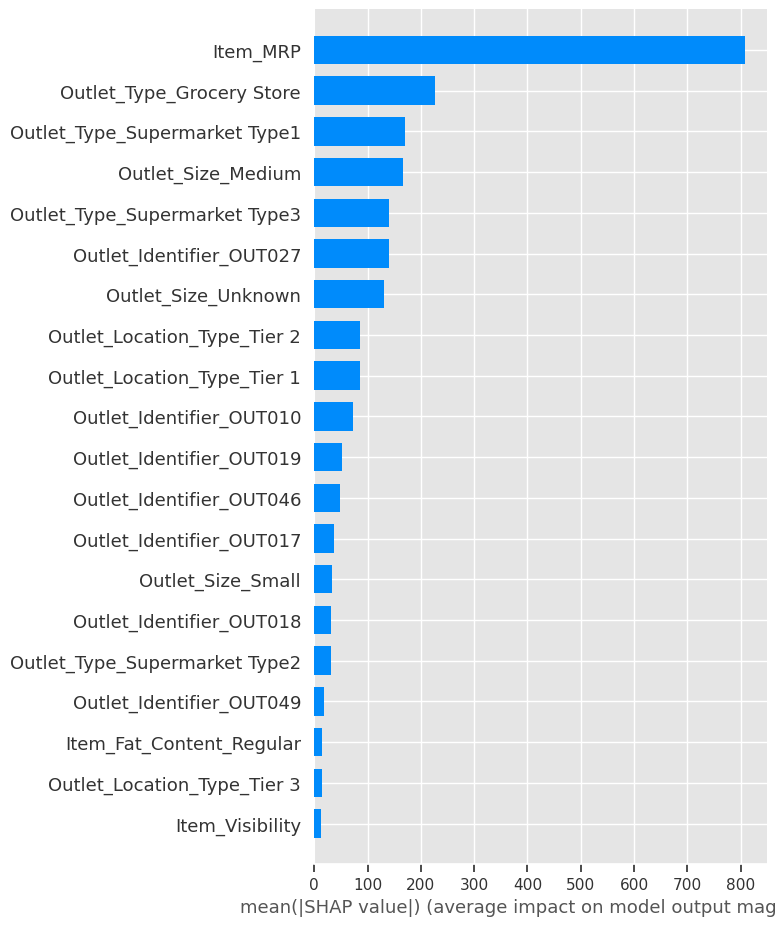

In [52]:
shap.summary_plot(shap_values_linreg, features = X_shap, plot_type='bar')

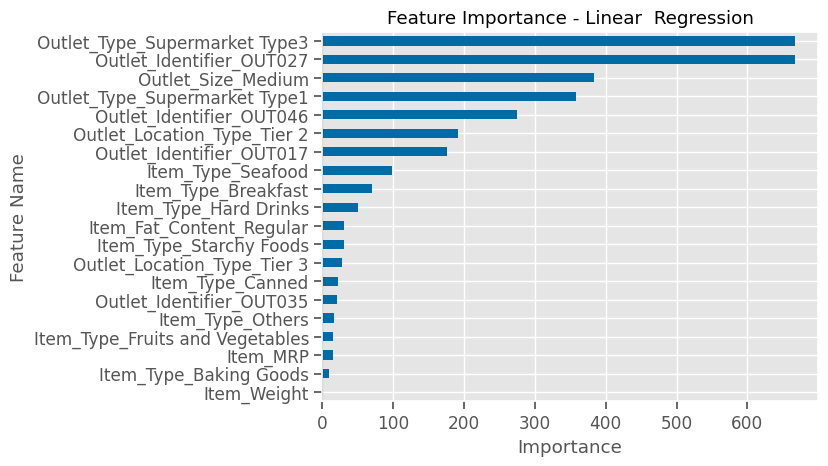

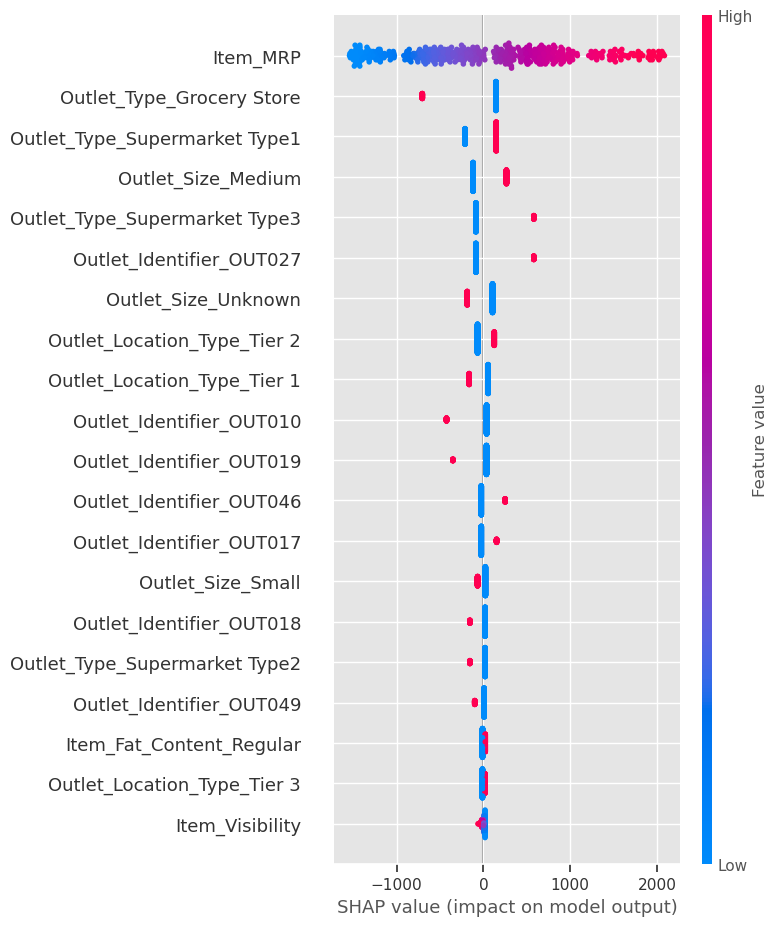

In [53]:
shap.summary_plot(shap_values_linreg, features = X_shap)


In [54]:
X_shap_local = X_shap.reset_index(drop=True)
y_shap_local = y_shap.reset_index(drop=True)
X_shap_local.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Fat_Content_Regular,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,...,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Size_Unknown,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
0,7.72,0.07,76.40,"1,987.00",1.00,0.00,1.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00
1,5.11,0.03,163.82,"2,004.00",0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00
2,8.05,0.08,256.46,"2,004.00",1.00,0.00,0.00,0.00,0.00,0.00,...,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00
3,8.76,0.05,128.33,"1,999.00",0.00,0.00,0.00,0.00,0.00,0.00,...,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00
4,6.59,0.18,82.79,"1,998.00",0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,1.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00


In [55]:
# what is the max/range of infant deaths
X_shap_local['Item_MRP'].describe()

count   500.00
mean    137.08
std      61.60
min      32.36
25%      90.08
50%     140.43
75%     179.52
max     264.72
Name: Item_MRP, dtype: float64

In [57]:
idx_high_MRP = X_shap_local['Item_MRP'].idxmax()
idx_high_MRP

431

In [58]:
X_shap_local.iloc[idx_high_MRP]

Item_Weight                          10.00
Item_Visibility                       0.03
Item_MRP                            264.72
Outlet_Establishment_Year         2,009.00
Item_Fat_Content_Regular              0.00
Item_Type_Baking Goods                0.00
Item_Type_Breads                      0.00
Item_Type_Breakfast                   0.00
Item_Type_Canned                      1.00
Item_Type_Dairy                       0.00
Item_Type_Frozen Foods                0.00
Item_Type_Fruits and Vegetables       0.00
Item_Type_Hard Drinks                 0.00
Item_Type_Health and Hygiene          0.00
Item_Type_Household                   0.00
Item_Type_Meat                        0.00
Item_Type_Others                      0.00
Item_Type_Seafood                     0.00
Item_Type_Snack Foods                 0.00
Item_Type_Soft Drinks                 0.00
Item_Type_Starchy Foods               0.00
Outlet_Identifier_OUT010              0.00
Outlet_Identifier_OUT013              0.00
Outlet_Iden